In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import MetaData, Table, select

In [72]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
session = Session(engine)
connection = engine.connect()
print(engine.table_names())

['measurement', 'station']


In [65]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Msmt = Base.classes.measurement
Stn = Base.classes.station

In [66]:
#Get the table information
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [70]:
# Show the column information for measurement table
m_col = inspector.get_columns('measurement')
for c in m_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [71]:
# Show the column information for the station table
s_col = inspector.get_columns('station')
for c in s_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [315]:
def year_ago(date_str):
    new_date = datetime.strftime((datetime.strptime(date_str,'%Y-%m-%d') - dt.timedelta(days=365)).date(),'%Y-%m-%d')
    return new_date

In [316]:
year_ago('2018-06-24')

'2017-06-24'

In [331]:
from sqlalchemy.orm import aliased
from sqlalchemy import desc
import datetime as dt
from datetime import datetime, time

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
sel = [Msmt.date]
result = session.query(*sel).order_by(Msmt.date.desc()).first()
last_date = result[0]
last_date

'2017-08-23'

In [332]:
start_date = year_ago(last_date)
start_date

'2016-08-23'

In [339]:
# Perform a query to retrieve the data and precipitation scores
sel = [Msmt.date, 
       Msmt.prcp]
precip = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Msmt.date) >= start_date).\
    group_by(Msmt.date).\
    order_by(Msmt.date).all()
precip
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['date','precipitation'])
df.sort_values('date')
# Sort the dataframe by date
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


Text(0.5, 1.0, 'Precipitation from 2016-08-23 to 2017-08-23')

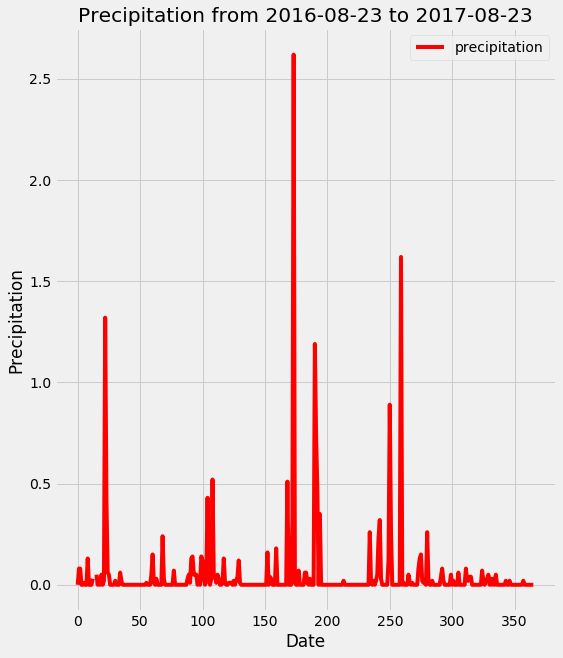

In [340]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(8,10),color='red')
plt.ylimit=(0,3)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title(f"Precipitation from {start_date} to {last_date}")

In [342]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [149]:
# Design a query to show how many stations are available in this dataset?

result = session.query(func.count(Stn.name)).distinct()
for item in result:
    print(item[0])

9


In [193]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results = session.query(Msmt.station, func.count(Msmt.station)).\
group_by(Msmt.station).order_by(func.count(Msmt.station).desc()).all()
for item in results:
    print(item)

most_active_station = results[0][0]
print(most_active_station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
USC00519281


In [194]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Msmt.tobs), 
       func.max(Msmt.tobs), 
       func.avg(Msmt.tobs),]
temp_data = session.query(*sel).\
    filter(Msmt.station == most_active_station).all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

In [247]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Msmt.date,Msmt.tobs]
temps = session.query(*sel).\
    filter(func.strftime("%Y-%m-%d", Msmt.date) > start_date).\
    filter(Msmt.station == most_active_station).\
    order_by(Msmt.tobs).all()
temps

df = pd.DataFrame(temps, columns=['date','temperature'])
# Sort the dataframe by date
df.sort_values('date')
df.head()

,date,temperature
0,2017-02-02,59.0
1,2017-02-08,59.0
2,2017-02-09,59.0
3,2017-02-03,60.0
4,2017-04-30,60.0


Text(0.5, 1.0, 'Temperatures from 2016-08-23 to 2017-08-23 at USC00519281')

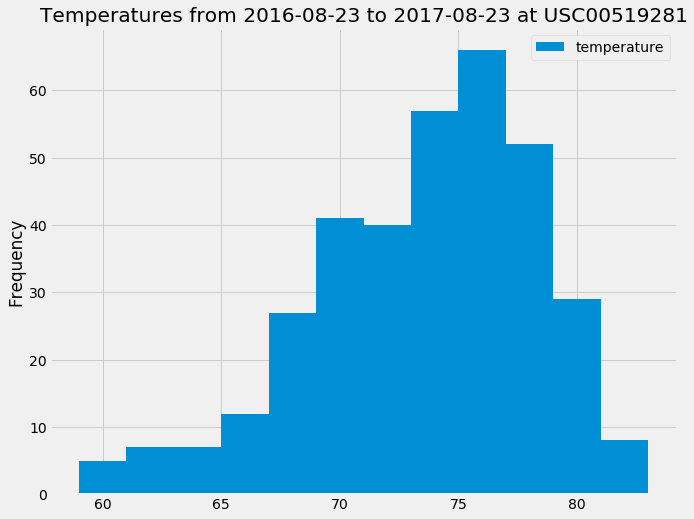

In [249]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot.hist(bins=12, figsize=(10,8))
plt.title(f"Temperatures from {start_date} to {last_date} at {most_active_station}")

In [251]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(71.0, 76.81052631578947, 83.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2018-06-10'
end_date = '2018-06-24'


In [314]:
year_ago_start = datetime.strftime((datetime.strptime(start_date,'%Y-%m-%d') - dt.timedelta(days=365)).date(),'%Y-%m-%d')

year_ago

'2017-06-10'

In [261]:
prev_year = calc_temps('2017-06-10', '2017-06-24')
tmin = prev_year[0][0]
tavg = round(prev_year[0][1],2)
tmax = prev_year[0][2]
tdif = tmax-tmin
print(f"The minimum temperature in your holiday period for the previous year was {tmin},\
 maximum {tmax} and average {tavg}. That's a swing of {tdif} degrees!")

The minimum temperature in your holiday period for the previous year was 71.0, maximum 83.0 and average 76.81. That's a swing of 12.0 degrees!


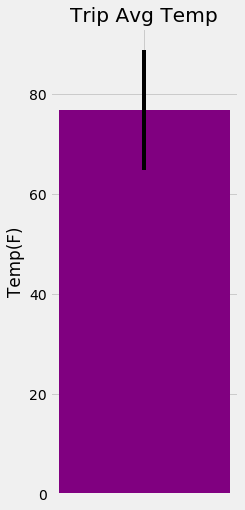

In [293]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8)) 
plt.bar(x='',height=tavg, yerr=tdif, color='purple')
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


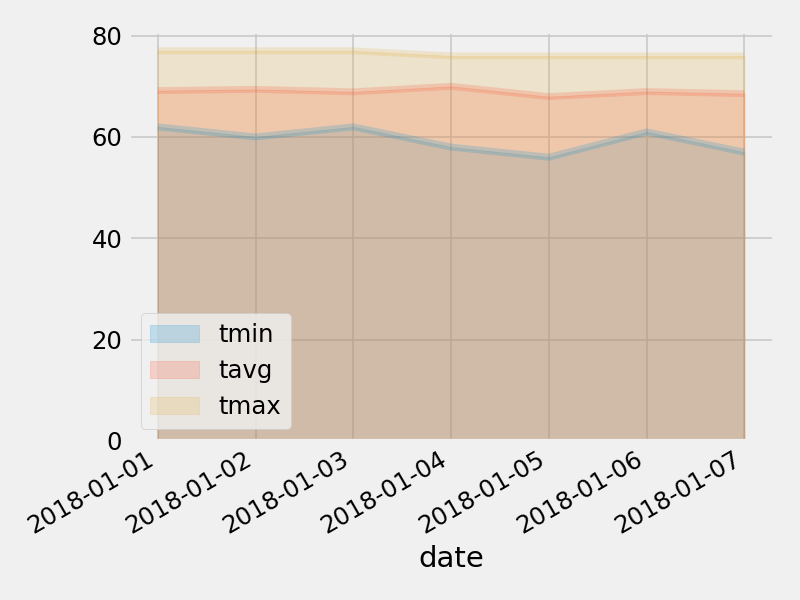

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
